In [26]:
import pandas as pd
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_curve, classification_report, matthews_corrcoef, confusion_matrix, precision_recall_curve

from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### Prepare Dataframe with features

In [2]:
df = pd.read_csv('./Datasets/My_Dataset/proteins_df_annotated.csv', index_col=0)
df = df[['uniprot_id', 'residue_1l', 'is_IBS']]
df

,uniprot_id,residue_1l,is_IBS
id,,,
0,P14555,M,0
1,P14555,K,0
2,P14555,T,0
3,P14555,L,0
4,P14555,L,0
...,...,...,...
325938,P01441,T,0
325939,P01441,D,0
325940,P01441,K,0


In [3]:
all_columns = ['uniprot_id', 'residue_1l']
feat_columns = []

# 1024 for protTrans
# 1280 for esm
for i in range(0,1280):
  all_columns.append('Feature_' + str(i + 1))
  feat_columns.append('Feature_' + str(i + 1))

all_columns.append('is_IBS')

In [4]:
f = open('./Datasets/My_Dataset/embeddings_esm.json')
embeddings_dict = json.load(f)
f.close()

In [ ]:
df_embeddings = pd.DataFrame(columns=all_columns)

for protein in tqdm(embeddings_dict.keys()):
  ibs_values = df[df.uniprot_id == protein].is_IBS.values
  temp_df = pd.DataFrame(np.array(embeddings_dict[protein]), columns=feat_columns)
  temp_df.insert(0,'uniprot_id',protein)
  temp_df.insert(1,'residue_1l',df[df.uniprot_id == protein].residue_1l.tolist())
  temp_df['is_IBS'] = ibs_values.tolist()

  df_embeddings = pd.concat([df_embeddings, temp_df], ignore_index=True, sort=False)

df_embeddings.to_csv('proteins_embeddings_esm_annotated.csv')

100%|██████████| 443/443 [1:18:09<00:00, 10.59s/it]


### Load dataframe and set train-test-val

In [3]:
# df = pd.read_csv('../Datasets/My_Dataset/proteins_embeddings_esm_annotated.csv', index_col=0)
df = pd.read_csv('../Datasets/My_Dataset/proteins_embeddings_protTrans_annotated.csv', index_col=0)
df

,uniprot_id,residue_1l,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_1272,Feature_1273,Feature_1274,Feature_1275,Feature_1276,Feature_1277,Feature_1278,Feature_1279,Feature_1280,is_IBS
0,O01761,M,0.051436,0.057840,-0.002832,0.040003,0.079338,0.021896,0.050686,-0.112886,...,-0.033487,-0.214859,-0.042207,0.021364,-0.003393,-0.007095,-0.160942,0.128649,0.002735,0
1,O01761,A,-0.063363,0.188756,-0.229877,0.050276,0.079548,-0.171778,0.108604,0.039983,...,0.197676,-0.114204,-0.001352,0.113371,0.030062,-0.122710,0.157325,0.054761,-0.073914,0
2,O01761,S,-0.154245,0.227232,-0.185334,0.012168,0.148100,-0.056722,0.065092,0.031289,...,0.081713,-0.119545,0.015701,0.188290,0.227505,-0.060425,0.220450,0.123903,-0.153156,0
3,O01761,R,0.036627,0.373738,-0.066661,0.132569,0.077150,-0.188361,-0.010662,0.117254,...,0.131667,-0.144065,0.113407,-0.077438,-0.052469,-0.085575,0.224432,-0.196661,-0.248436,0
4,O01761,R,-0.054136,0.169932,-0.131501,0.061030,0.031650,-0.164336,0.107642,0.028456,...,0.207674,-0.110496,-0.014361,0.091086,0.131275,-0.133346,0.138712,0.026365,-0.135246,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325938,P01441,T,-0.063050,-0.156123,-0.024356,0.306045,0.204681,0.126729,0.185344,-0.071489,...,0.088493,0.158650,-0.035943,0.039711,-0.132667,0.230300,-0.280772,0.166818,-0.113874,0
325939,P01441,D,-0.147620,-0.060844,-0.206223,0.033649,0.167042,-0.270832,-0.000974,-0.248665,...,0.067822,0.005815,-0.137717,0.053914,0.290871,0.257227,-0.101212,-0.149518,-0.164374,0
325940,P01441,K,-0.143371,-0.321767,-0.308143,0.256336,-0.222516,-0.122124,0.151273,-0.164138,...,0.018976,-0.267598,0.065262,0.133239,0.087251,0.131562,-0.134833,-0.130386,0.114424,0
325941,P01441,C,0.148909,0.094213,0.298960,0.271658,0.097396,-0.417317,0.205594,-0.042907,...,0.127418,-0.341982,-0.366732,0.327198,-0.259981,0.394668,-0.191575,-0.055792,-0.273750,0


In [4]:
# convert residues to one-hot encode
df_res = pd.get_dummies(df['residue_1l'])
df = df.merge(df_res, left_index=True, right_index=True, how='inner')
df.head(5)

,uniprot_id,residue_1l,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,M,N,P,Q,R,S,T,V,W,Y
0,O01761,M,0.051436,0.057840,-0.002832,0.040003,0.079338,0.021896,0.050686,-0.112886,...,1,0,0,0,0,0,0,0,0,0
1,O01761,A,-0.063363,0.188756,-0.229877,0.050276,0.079548,-0.171778,0.108604,0.039983,...,0,0,0,0,0,0,0,0,0,0
2,O01761,S,-0.154245,0.227232,-0.185334,0.012168,0.148100,-0.056722,0.065092,0.031289,...,0,0,0,0,0,1,0,0,0,0
3,O01761,R,0.036627,0.373738,-0.066661,0.132569,0.077150,-0.188361,-0.010662,0.117254,...,0,0,0,0,1,0,0,0,0,0
4,O01761,R,-0.054136,0.169932,-0.131501,0.061030,0.031650,-0.164336,0.107642,0.028456,...,0,0,0,0,1,0,0,0,0,0


In [8]:
print('Total number of proteins %d ' % len(df.uniprot_id.unique()))

# for proteins that do not belong to Peprmint dataset and belong to Dreamm dataset (so we don't have a lot of information) will become the evaluation dataset
uniprot_id_val = ['P61914', 'Q15075', 'O16025', 'Q96QK1', 'Q960X8', 'P12530', 'P00735', 'P40343', 'O24592', 'P05979', 'O88339', 'P22637', 'Q28175', 'P08684', 'P0C2E9', 'Q9LCB2', 'P60484', 'P0C216', 'Q02127', 'P20932', 'P02749', 'P11889', 'Q77DJ6', 'P00803', 'Q99685', 'P49638', 'Q9NZD2', 'P00720', 'P12724', 'P12104', 'P56254', 'P60980', 'P01441']
df_val = df[df.uniprot_id.isin(uniprot_id_val)]

f = open('../Datasets/My_Dataset/split_proteins.json')
dict_proteins_split = json.load(f)
f.close()

df_train = df[df.uniprot_id.isin(dict_proteins_split['train'])]
df_test = df[df.uniprot_id.isin(dict_proteins_split['test'])]
df_val = df[df.uniprot_id.isin(dict_proteins_split['val'])]

X_train, y_train = df_train.drop(['uniprot_id', 'residue_1l', 'is_IBS'], axis=1, inplace=False), df_train['is_IBS']
X_test, y_test = df_test.drop(['uniprot_id', 'residue_1l', 'is_IBS'], axis=1, inplace=False), df_test['is_IBS']
X_val, y_val = df_val.drop(['uniprot_id', 'residue_1l', 'is_IBS'], axis=1, inplace=False), df_val['is_IBS']

Total number of proteins 443 


Text(0, 0.5, 'Number of Amino acids')

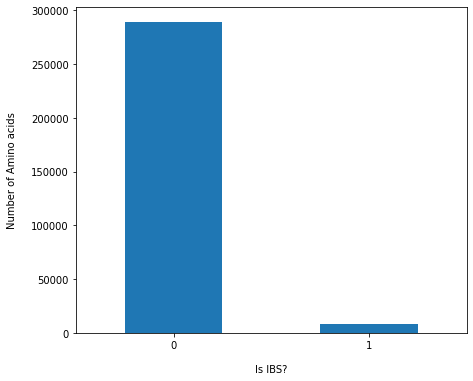

In [5]:
df_train.is_IBS.value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Is IBS?", labelpad=14)
plt.ylabel("Number of Amino acids", labelpad=14)
# observe a totally imbalanced dataset

In [19]:
ratio = df_train.is_IBS.value_counts()[0]/df_train.is_IBS.value_counts()[1]
print(df_train.is_IBS.value_counts())
print("Ratio is %f" % ratio)
print(np.sqrt(ratio))

Ratio is 34.766963
5.896351704772326


In [5]:
X_train, y_train = df_train.drop(['uniprot_id', 'residue_1l', 'is_IBS'], axis=1, inplace=False), df_train['is_IBS']
X_test, y_test = df_test.drop(['uniprot_id', 'residue_1l', 'is_IBS'], axis=1, inplace=False), df_test['is_IBS']

In [6]:
del df_train
del df_test
del df
del df_res

In [20]:
from sklearn.utils import compute_class_weight
print(compute_class_weight('balanced', classes=[0, 1], y=y_train))

[ 0.51438147 17.88348171]


### XGBoost

F1 score: 0.297 
MCC: 0.314 
Balanced accuracy: 0.589 
       0    1
0  11953  168
1   1310  312


<AxesSubplot:>

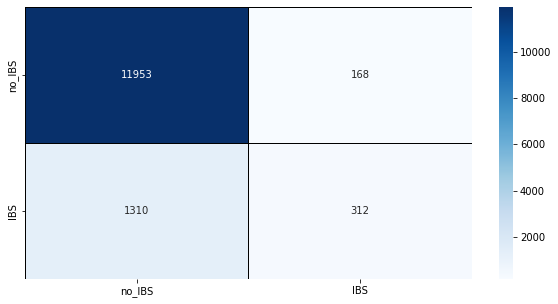

In [21]:
clf = XGBClassifier(objective='binary:logistic', scale_pos_weight=np.sqrt(ratio), random_state=0, n_jobs=7)
clf.fit(X_train, y_train)

ypred = clf.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred))
print('Balanced accuracy: %.3f ' % balanced_accuracy_score(y_test, ypred))

cm = confusion_matrix(y_test, ypred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

plt.figure(figsize = (10,5))
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ['no_IBS', 'IBS'],yticklabels = ['no_IBS', 'IBS'])

Total fit time: ~10m - protTrans
<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax" rowspan="2"></th>
    <th class="tg-uca5" colspan="3">scale_pos_weight</th>
  </tr>
  <tr>
    <th class="tg-8zwo">34.7 sum(neg)/sum(pos)</th>
    <th class="tg-8zwo"><span style="font-weight:400;font-style:normal">48</span></th>
    <th class="tg-8zwo">30</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-1wig">F1_score</td>
    <td class="tg-0lax">0.581</td>
    <td class="tg-0lax">0.571</td>
    <td class="tg-0lax">0.578</td>
  </tr>
  <tr>
    <td class="tg-1wig">MCC</td>
    <td class="tg-0lax">0.522</td>
    <td class="tg-0lax">0.511</td>
    <td class="tg-0lax">0.519</td>
  </tr>
  <tr>
    <td class="tg-1wig">Balanced_acc</td>
    <td class="tg-0lax">0.785</td>
    <td class="tg-0lax">0.79</td>
    <td class="tg-0lax">0.783</td>
  </tr>
  <tr>
    <td class="tg-0lax"></td>
    <td class="tg-0lax">Best FP (941) FN (573)</td>
    <td class="tg-0lax">A lot FP (1097)</td>
    <td class="tg-0lax">less FP than 34 (947)</td>
  </tr>
</tbody>
</table>

Total fit time: ~10m - ESM
<table class="tg">
<thead>
  <tr>
    <th class="tg-0lax" rowspan="2"></th>
    <th class="tg-uca5" colspan="1">scale_pos_weight</th>
  </tr>
  <tr>
    <th class="tg-8zwo">34.7 sum(neg)/sum(pos)</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-1wig">F1_score</td>
    <td class="tg-0lax">0.418</td>
  </tr>
  <tr>
    <td class="tg-1wig">MCC</td>
    <td class="tg-0lax">0.365</td>
  </tr>
  <tr>
    <td class="tg-1wig">Balanced_acc</td>
    <td class="tg-0lax">0.653</td>
  </tr>
  <tr>
    <td class="tg-0lax"></td>
    <td class="tg-0lax">FP (526) FN (1055)</td>
  </tr>
</tbody>
</table>

### Random Forest

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=0, n_jobs=6) # try also -> balanced_subsample

# fit the predictor and target
rfc.fit(X_train, y_train)

# evaluate model on the traindataset
ypred = rfc.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred))
print('Balanced accuracy: %.3f ' % balanced_accuracy_score(y_test, ypred))
print('Accuracy: %.3f ' % accuracy_score(y_test, ypred))
print('ROC : %.3f ' % roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1]))

cm = confusion_matrix(y_test, ypred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

In [ ]:
rbfc = BalancedRandomForestClassifier(random_state=0, n_jobs=6)

# fit the predictor and target
rbfc.fit(X_train, y_train)

# evaluate model on the traindataset
ypred = rbfc.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred))
print('Balanced accuracy: %.3f ' % balanced_accuracy_score(y_test, ypred))
print('Accuracy: %.3f ' % accuracy_score(y_test, ypred))
print('ROC : %.3f ' % roc_auc_score(y_test, rbfc.predict_proba(X_test)[:, 1]))

cm = confusion_matrix(y_test, ypred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

Total fit time ~1-3m - protTrans
<table class="tg">
<thead>
  <tr>
    <th rowspan="2"></th>
    <th colspan="3">Randomforest</th>
    <th colspan="3">BalancedRandomForest</th>
  </tr>
  <tr>
    <th>'balanced' class weight</th>
    <th>'balanced_subsample' class weight</th>
    <th>nothing</th>
    <th>n_estimators = 150</th>
    <th>n_estimators = 1000</th>
    <th>'balanced' class weight</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>F1_score</td>
    <td>0.0</td>
    <td>0.0</td>
    <td>0.0</td>
    <td>0.487</td>
    <td>0.493</td>
    <td>0.446</td>
  </tr>
  <tr>
    <td>MCC</td>
    <td>0.0</td>
    <td>0.0</td>
    <td>0.023</td>
    <td>0.429</td>
    <td>0.437</td>
    <td>0.365</td>
  </tr>
  <tr>
    <td>Balanced_acc</td>
    <td>0.5</td>
    <td>0.5</td>
    <td>0.5</td>
    <td>0.788</td>
    <td>0.793</td>
    <td>0.716</td>
  </tr>
  <tr>
    <td>ROC auc</td>
    <td>0.842</td>
    <td>0.841</td>
    <td>0.795</td>
    <td>0.866</td>
    <td>0.872</td>
    <td>0.824</td>
  </tr>
  <tr>
    <td></td>
    <td>All FN and no TP</td>
    <td>All FN and no TP</td>
    <td>All FN and 1 TP</td>
    <td>A lot FP (2194)</td>
    <td>Not many FP (1520) FN (719)</td>
    <td>FP (1520) & FN (719)</td>
  </tr>
</tbody>
</table>

Total fit time ~1-3m - ESM
<table class="tg">
<thead>
  <tr>
    <th rowspan="2"></th>
    <th colspan="3">Randomforest</th>
  </tr>
  <tr>
    <th>'balanced' class weight</th>
    <th>class weight = {}</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>F1_score</td>
    <td>0.</td>
    <td>0.</td>
  </tr>
  <tr>
    <td>MCC</td>
    <td>0.</td>
    <td>0.</td>
  </tr>
  <tr>
    <td>Balanced_acc</td>
    <td>0.</td>
    <td>0.</td>
  </tr>
  <tr>
    <td></td>
    <td>All FN and no TP</td>
    <td>All FN and no TP</td>
  </tr>
</tbody>
</table>

### SVM

In [18]:
clf_svc = svm.SVC(kernel='linear', C = 100, random_state=0)

clf_svc.fit(X_train, y_train)

# evaluate model on the traindataset
ypred = clf_svc.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred))
print('Balanced accuracy: %.3f ' % balanced_accuracy_score(y_test, ypred))
print('Accuracy: %.3f ' % accuracy_score(y_test, ypred))
print('ROC : %.3f ' % roc_auc_score(y_test, clf_svc.predict_proba(X_test)[:, 1]))

cm = confusion_matrix(y_test, ypred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

In [7]:
wclf_svc = svm.SVC(kernel='linear', class_weight='balanced', # penalize  class_weight={1: 100},
                  probability=True, random_state=0)

wclf_svc.fit(X_train, y_train)

# evaluate model on the traindataset
ypred = wclf_svc.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred))
print('Balanced accuracy: %.3f ' % balanced_accuracy_score(y_test, ypred))
print('Accuracy: %.3f ' % accuracy_score(y_test, ypred))
print('ROC : %.3f ' % roc_auc_score(y_test, wclf_svc.predict_proba(X_test)[:, 1]))

cm = confusion_matrix(y_test, ypred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)
# 4.730m

### Single-layer Perceptron

In [32]:
clf = Perceptron(random_state=0, class_weight={0:1, 1:33}, n_jobs=6)
clf.fit(X_train, y_train)

ypred = clf.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred))
print('Balanced accuracy: %.3f ' % balanced_accuracy_score(y_test, ypred))

cm = confusion_matrix(y_test, ypred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

F1 score: 0.478 
MCC: 0.407 
Balanced accuracy: 0.753 
       0     1
0  10402  1719
1    572  1050


Total fit time: 3m - protTrans
<table class="tg">
<thead>
  <tr>
  <th> </th>
    <th>'balanced' class weight</th>
    <th>{0:1, 1:30}</th>
    <th>{0:1, 1:34.7}</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>F1_score</td>
    <td>0.477</td>
    <td>0.473</td>
    <td>0.484</td>
  </tr>
  <tr>
    <td>MCC</td>
    <td>0.387</td>
    <td>0.404</td>
    <td>0.421</td>
  </tr>
  <tr>
    <td>Balanced_acc</td>
    <td>0.771</td>
    <td>0.76</td>
    <td>0.776</td>
  </tr>
  <tr>
    <td></td>
    <td>Many FP (2679) and less FN (385)</td>
    <td>FP (1949) and less FN (517)</td>
    <td>Many FP (2040) and less FN (453)</td>
  </tr>
</tbody>
</table>

Total fit time: 3m - ESM
<table class="tg">
<thead>
  <tr>
  <th> </th>
    <th>'balanced' class weight</th>
    <th>{0:1, 1:33}</th>
    <th>{0:1, 1:34.7}</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>F1_score</td>
    <td>0.</td>
    <td>0.478</td>
    <td>0.409</td>
  </tr>
  <tr>
    <td>MCC</td>
    <td>0.</td>
    <td>0.407</td>
    <td>0.350</td>
  </tr>
  <tr>
    <td>Balanced_acc</td>
    <td>0.</td>
    <td>0.753</td>
    <td>0.757</td>
  </tr>
  <tr>
    <td></td>
    <td>Many FP () and less FN ()</td>
    <td>FP (1719) and less FN (572)</td>
    <td>Many FP (3375) and less FN (337)</td>
  </tr>
</tbody>
</table>

In [16]:
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu',input_shape=(X_train.shape[-1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=None),
])


model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=keras.metrics.BinaryAccuracy(name='accuracy'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 16)                20816     
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 20,833
Trainable params: 20,833
Non-trainable params: 0
_________________________________________________________________


In [17]:
weight_for_0 = (1 / y_train.value_counts()[0]) * (y_train.count() / 2.0)
weight_for_1 = (1 / y_train.value_counts()[1]) * (y_train.count() / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

EPOCHS = 30
BATCH_SIZE = 2048

model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weight
    )

Epoch 1/30


2023-02-09 15:56:54.652721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 2s 10ms/step - loss: 0.1064 - accuracy: 0.9720
Epoch 2/30
146/146 [==============================] - 1s 9ms/step - loss: 0.0719 - accuracy: 0.9743
Epoch 3/30
146/146 [==============================] - 1s 9ms/step - loss: 0.0622 - accuracy: 0.9769
Epoch 4/30
146/146 [==============================] - 1s 9ms/step - loss: 0.0575 - accuracy: 0.9781
Epoch 5/30
146/146 [==============================] - 1s 9ms/step - loss: 0.0546 - accuracy: 0.9790
Epoch 6/30
146/146 [==============================] - 1s 9ms/step - loss: 0.0525 - accuracy: 0.9799
Epoch 7/30
146/146 [==============================] - 1s 9ms/step - loss: 0.0506 - accuracy: 0.9804
Epoch 8/30
146/146 [==============================] - 1s 9ms/step - loss: 0.0495 - accuracy: 0.9809
Epoch 9/30
146/146 [==============================] - 1s 9ms/step - loss: 0.0486 - accuracy: 0.9813
Epoch 10/30
146/146 [==============================] - 1s 9ms/step - loss: 0.0471 - accuracy: 0.9817
Epoch 11/

In [18]:
ypred = model.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred > 0.58))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred > 0.5))
print('Balanced accuracy: %.3f ' % balanced_accuracy_score(y_test, ypred > 0.5))

cm = confusion_matrix(y_test, ypred > 0.5)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

 84/430 [====>.........................] - ETA: 0s

2023-02-09 15:57:43.812063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


430/430 [==============================] - 1s 2ms/step
F1 score: 0.433 
MCC: 0.452 
Balanced accuracy: 0.666 
       0    1
0  11872  249
1   1050  572


Total fit time -> 50 epochs - 1m30s - protTrans
<table class="tg">
<thead>
  <tr>
  <th> </th>
    <th>With class weight</th>
    <th>Without class weight</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>F1_score</td>
    <td>0.581</td>
    <td>0.582</td>
  </tr>
  <tr>
    <td>MCC</td>
    <td>0.526</td>
    <td>0.549</td>
  </tr>
  <tr>
    <td>Balanced_acc</td>
    <td>0.809</td>
    <td>0.733</td>
  </tr>
  <tr>
    <td></td>
    <td>FP (1229) - FN (455)</td>
    <td>FP (323) - FN (823)</td>
  </tr>
</tbody>
</table>

Total fit time -> 50 epochs - 1m30s - ESM
<table class="tg">
<thead>
  <tr>
  <th> </th>
    <th>With class weight</th>
    <th>Without class weight</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>F1_score</td>
    <td>0.496</td>
    <td>0.433</td>
  </tr>
  <tr>
    <td>MCC</td>
    <td>0.425</td>
    <td>0.452</td>
  </tr>
  <tr>
    <td>Balanced_acc</td>
    <td>0.781</td>
    <td>0.666</td>
  </tr>
  <tr>
    <td></td>
    <td>FP (2089) - FN (432)</td>
    <td>FP (209) - FN (1150)</td>
  </tr>
</tbody>
</table>

### Multi-layer Perceptron

In [21]:
clf = MLPClassifier(random_state=1, max_iter=300, hidden_layer_sizes=(100,)).fit(X_train, y_train)

ypred = clf.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred))
print('Balanced accuracy: %.3f ' % balanced_accuracy_score(y_test, ypred))

cm = confusion_matrix(y_test, ypred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

F1 score: 0.524 
MCC: 0.511 
Balanced accuracy: 0.693 
      0    1
0  6795  117
1   516  348


Total time: ~60m - protTRans

<table class="tg">
<thead>
  <tr>
  <th> </th>
    <th>100 hiden layer / 0.001 lr / Adams / relu</th>
    <th>50 hiden layer / 0.001 lr / Adams / relu</th>
    <th>150 hiden layer / 0.001 lr / Adams / relu</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>F1_score</td>
    <td>0.619</td>
    <td>0.601</td>
    <td>0.627</td>
  </tr>
  <tr>
    <td>MCC</td>
    <td>0.577</td>
    <td>0.556</td>
    <td>0.586</td>
  </tr>
  <tr>
    <td>Balanced_acc</td>
    <td>0.766</td>
    <td>0.755</td>
    <td>0.770</td>
  </tr>
  <tr>
    <td>ROC auc</td>
    <td>0.909</td>
    <td>0.902</td>
    <td>0.911</td>
  </tr>
  <tr>
    <td></td>
    <td>Less FP (426) and more FN (703)</td>
    <td>FP (445) - FN (735)</td>
    <td>FP (419) - FN (689)</td>
  </tr>
</tbody>
</table>

In [24]:
model = keras.Sequential([
    keras.layers.Dense(256, activation='relu',input_shape=(X_train.shape[-1],)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=None),
])


model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=keras.metrics.BinaryAccuracy(name='accuracy'))

model.summary()

weight_for_0 = (1 / y_train.value_counts()[0]) * (y_train.count() / 2.0)
weight_for_1 = (1 / y_train.value_counts()[1]) * (y_train.count() / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

EPOCHS = 30
BATCH_SIZE = 2048

model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weight
    )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 256)               333056    
                                                                 
 dense_23 (Dense)            (None, 256)               65792     
                                                                 
 dense_24 (Dense)            (None, 512)               131584    
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                                 
 dense_28 (Dense)            (None, 1)                

2023-04-03 19:54:38.060883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 4s 23ms/step - loss: 0.2597 - accuracy: 0.8852
Epoch 2/30
146/146 [==============================] - 3s 22ms/step - loss: 0.1182 - accuracy: 0.9452
Epoch 3/30
146/146 [==============================] - 3s 21ms/step - loss: 0.0863 - accuracy: 0.9573
Epoch 4/30
146/146 [==============================] - 3s 22ms/step - loss: 0.0673 - accuracy: 0.9670
Epoch 5/30
146/146 [==============================] - 3s 21ms/step - loss: 0.0566 - accuracy: 0.9730
Epoch 6/30
146/146 [==============================] - 3s 22ms/step - loss: 0.0531 - accuracy: 0.9746
Epoch 7/30
146/146 [==============================] - 3s 22ms/step - loss: 0.0451 - accuracy: 0.9779
Epoch 8/30
146/146 [==============================] - 3s 21ms/step - loss: 0.0415 - accuracy: 0.9806
Epoch 9/30
146/146 [==============================] - 3s 22ms/step - loss: 0.0371 - accuracy: 0.9831
Epoch 10/30
146/146 [==============================] - 3s 21ms/step - loss: 0.0322 - accuracy: 0.9852


In [27]:
ypred = model.predict(X_test)

print('F1 score: %.3f ' % f1_score(y_test, ypred > 0.5))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred > 0.5))

cm = confusion_matrix(y_test, ypred > 0.5)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

243/243 [==============================] - 1s 3ms/step
Best Threshold=0.224931, F-Score=0.580
F1 score: 0.571 
MCC: 0.521 
      0    1
0  6597  315
1   393  471


Total time: ~1m30s - ESM

<table class="tg">
<thead>
  <tr>
  <th> </th>
    <th>3 hiden layer / 0.001 lr / Adams / relu</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>F1_score</td>
    <td>0.553</td>
  </tr>
  <tr>
    <td>MCC</td>
    <td>0.492</td>
  </tr>
  <tr>
    <td>Balanced_acc</td>
    <td>0.753</td>
  </tr>
  <tr>
    <td></td>
    <td>Less FP (693) and more FN (807)</td>
  </tr>
</tbody>
</table>

In [27]:
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.5143814688061236, 1: 17.883481713185756}